In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

Install all the dependencies to make the most out of TorchCAM

In [ ]:
!pip install torchvision matplotlib

## Latest stable release

In [ ]:
!pip install torchcam

## From source

Now go to `Runtime/Restart runtime` for your changes to take effect!

# Basic usage

In [ ]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [ ]:
img_path='/content/drive/MyDrive/Copy of IMG_20220305_104147__01.jpg'

In [ ]:
# Instantiate your model here
model = resnet18(pretrained=True).eval()

## Illustrate your classifier capabilities

In [ ]:
cam_extractor = SmoothGradCAMpp(model)
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([7, 7])


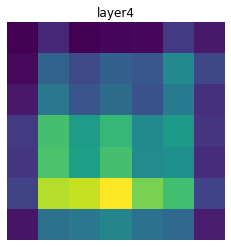

In [ ]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.numpy()); plt.axis('off'); plt.title(name); plt.show()

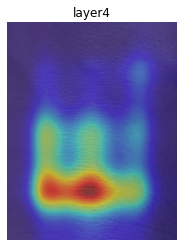

In [ ]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam, mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [ ]:
# Once you're finished, clear the hooks on your model
cam_extractor.clear_hooks()

# Advanced tricks

## Extract localization cues

In [ ]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
print(softmax(out, dim=1).max())

tensor(0.0450, grad_fn=<MaxBackward1>)


In [ ]:
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

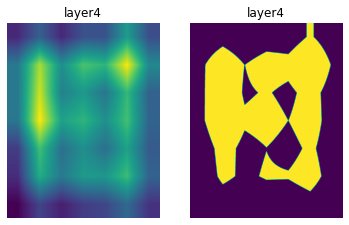

In [ ]:
# Resize it
resized_cams = [resize(to_pil_image(cam), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam.unsqueeze(0), img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()

In [ ]:
# Once you're finished, clear the hooks on your model
cam_extractor.clear_hooks()

## Fuse CAMs from multiple layers

In [ ]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["layer2", "layer3", "layer4"])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
# This time, there are several CAMs
for cam in cams:
  print(cam.shape)

torch.Size([28, 28])
torch.Size([14, 14])
torch.Size([7, 7])


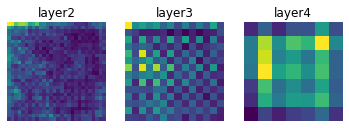

In [ ]:
# The raw CAM
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

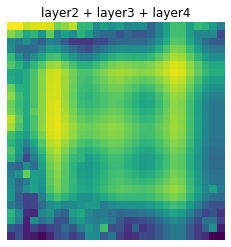

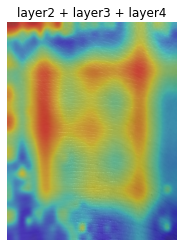

In [ ]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [ ]:
# Once you're finished, clear the hooks on your model
cam_extractor.clear_hooks()